In [27]:
projectdir = "C:/Users/Arman Angaji/OneDrive - Universität zu Köln/Dokumente/Uni-Köln/Masterarbeit/Workspace/Julia_Master/MasterProject_Julia"
using Pkg; Pkg.activate(projectdir)

using DataFrames, StatsBase, Plots, Statistics, LaTeXStrings, Interact, LsqFit, CSV, Blink, Pipe, ProgressMeter, StatsPlots
pyplot()

try
    Turnover
catch e
    include("Turnover.jl")
    include("test.jl")
    using .Turnover
end

import TumorGrowth
include(projectdir*"/distribution_functions.jl")
include(projectdir*"/simulated_tumors/path_format.jl")
include("utility.jl")
plot(size=(1,1))

  Activating environment at `C:\Users\Arman Angaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\Project.toml`


In [28]:
tumorinfo = dir_info(projectdir*"/simulated_tumors/2d/bulk")
filter!(x-> x.N == 10000 && x.μ == 0.2 && x.d in 0.:0.2:0.8, tumorinfo)
for x in groupby(tumorinfo, :d)
    print("d=",first(x.d), ": ", nrow(x), ", ")
end

d=0.0: 10, d=0.2: 28, d=0.4: 34, d=0.6: 46, d=0.8: 40, 

In [30]:
using Distributed
tumorinfo.tumor = @showprogress pmap(TumorGrowth.data_import, tumorinfo.path);

Progress: 100%|█████████████████████████████████████████| Time: 0:08:43


In [9]:
# mes2theory_orphaned(t_mes, p = [0.188, 17.688]) = @. p[1]*( 1/(1+exp(-p[2]*t_mes)) -1/2 )

# mes2theory_estranged(t_mes, p = [0.603, 1.267]) = map(t_mes) do t
#     if p[1]/p[2] > 1/2 
#         10
#     else
#         t >= p[1] ? 1. : log( 1/ ( t*1/p[2] + 1/2 ) - 1 ) / log( 1/ ( p[1]/p[2] + 1/2 ) - 1)
#     end
# end

mes2theory_estranged (generic function with 2 methods)

In [32]:
function bisection(f, interval, iter; precision=1e-9)
    xlow, xup = interval
    sign(f(xlow)) == sign(f(xup)) && error("no zero in interval $interval")
    any((isnan.(f.(interval)))) && error("f not defined on interval $interval")
    for i=1:iter
        xm = (xlow+xup)/2
        abs(f(xm)) < precision && return (xm, i)
        if sign(f(xm)) != sign(f(xlow))
            xup = xm
        else
            xlow = xm
        end
    end
    println(xup)
    error("no convergence within $iter steps")
end

bisection (generic function with 1 method)

In [33]:
using Distributions, NLsolve, Roots
z = nlsolve(x->cdf.(Normal(), x) .- 0.975, [1.]).zero[1]

1.9599639704623484

In [5]:
tumorinfo = dir_info(projectdir*"/simulated_tumors/2d")
append!(tumorinfo, dir_info(projectdir*"/simulated_tumors/2d/bulk"))
append!(tumorinfo, dir_info(projectdir*"/simulated_tumors/3d"))

N, b, d, mu, rho, Nthresh = 40000, 0.69, 0.3, 0.3, 30., 200
path = filter(t -> t.N == N && t.d == d && t.b == b && t.μ==mu && t.ρ ==rho && t.dim==3, tumorinfo).path |> rand
tumor = TumorGrowth.data_import(path)

htypes = unique(tumor.mutations)
freqs = TumorGrowth.mutation_freqs(tumor) |> seq -> Dict(seq.mutation .=> seq.frequency)

orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/Nthresh, htypes) ) )
estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/Nthresh for m in muts), htypes) )

(orphaned_tumor, estranged_tumor) .|> nrow |> println

(108, 91)


In [5]:
Ls = 0.2:0.1:1.
reps = 50
estranged_tumors = map( Ls ) do L
    [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
end

estranged_turnover = map(estranged_tumors) do set
        filter!(!isnan, map(set) do tumor
            res = estranged_treeless(tumor)
            sum(res.isestranged)/sum(res.isgreen)
        end )
    end
;

### Infering `d` from orphaned turnover and `μ` from estranged turnover

#### Get `q` given orphaned turnover of tumor

 d : 0.3
0.3514266470580824


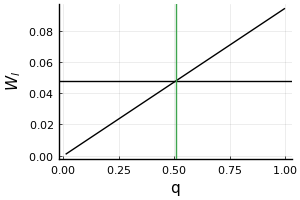

In [18]:
let W_l = orphaned_red_treeless(orphaned_tumor) |>
                df -> sum(df.isorphaned)/sum(df.isgreen) |> mes2theory_orphaned

    qval = min(1., 2*log(Nthresh)*W_l)
    println(" d : ", d)
    println(qval * b)
    plot(0.01:0.01:1., q->W_orphaned(q;N=Nthresh), legend=:none, size=(300,200), c=:black, xlab=:q, ylab=L"W_l")
    hline!([W_l], c=:black); vline!([qval], lab="")
end

W : 0.050147380054560965 ± 0.001994034434488885
q : 0.5313934692599299 ± 0.021130054547494496
d : 0.3666614937893516 ± 0.014579737637771201


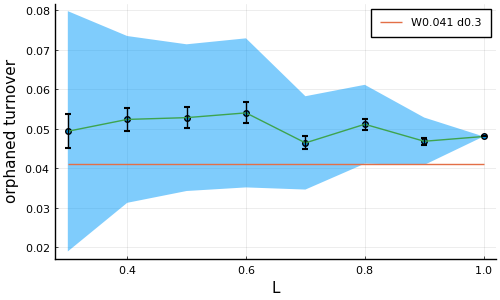

In [20]:
let Ls = 0.3:0.1:1.
    orphaned_tumors = map( Ls ) do L
        [TumorGrowth.reduced_μ(orphaned_tumor, L) for _=1:reps]
    end

    t = map(orphaned_tumors) do set
        filter!(!isnan, map(set) do tumor
            res = orphaned_red_treeless(tumor)
            sum(res.isorphaned)/sum(res.isgreen)
                end ) |> mes2theory_orphaned
    end

    qvals = map(t) do Ws
            2*log(Nthresh).*Ws
        end

    global d, b, Nthresh
    p = scatter(Ls, mean.(t), ribbon=std.(t), lab="", xlab=:L, ylab="orphaned turnover", size=(500,300))
    plot!(Ls, L-> W_orphaned(d/b; N=Nthresh),
        lab="W$(round(W_orphaned(d/b; N=Nthresh),digits=3)) d$d" )
    plot!(Ls, mean.(t), yerror=std.(t)./sqrt.(length.(t)), lab="" )

    println("W : ", mean(mean.(t)), " ± ", 1.96*std(mean.(t))/sqrt(length(t)) )
    println("q : ", mean(mean.(qvals)), " ± ", 1.96*std(mean.(qvals))/sqrt(length(t)) )
    println("d : ", mean(mean.(qvals))*b, " ± ", 1.96*std(mean.(qvals))/sqrt(length(t)) * b )
    p
end

#### Given `d` compute `μ` from estranged turnover of tumor

In [21]:
function bisection(f, interval, iter; precision=1e-9)
    xlow, xup = interval
    sign(f(xlow)) == sign(f(xup)) && error("no zero in interval $interval")
    any((isnan.(f.(interval)))) && error("f not defined on interval $interval")
    for i=1:iter
        xm = (xlow+xup)/2
        abs(f(xm)) < precision && return (xm, i)
        if sign(f(xm)) != sign(f(xlow))
            xup = xm
        else
            xlow = xm
        end
    end
    println(xup)
    error("no convergence within $iter steps")
end

bisection (generic function with 1 method)

μ : 0.3
0.2827518764138222


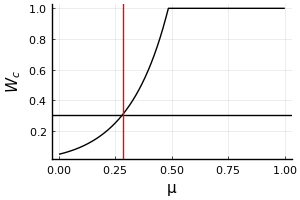

In [23]:
let d = 0.35
    global b, Nthresh, mu
    
    W_c = estranged_treeless(estranged_tumor) |> df -> sum(df.isestranged)/sum(df.isgreen) |> mes2theory_estranged

    mu_solve, n = bisection(mu -> min(1., W_estranged(d; b=b, μ=mu, T=log(Nthresh)/(b-d)))- W_c, [0.01,0.99], 100)
#     mu_solve = fzero(mu -> min(1., W_estranged(d; b=b, μ=mu, T=log(Nthresh)/(b-d)))- W_c, 0.01, 1.)

    println("μ : ", mu)
    println(mu_solve)
    plot(0.:0.001:1., mu -> min(1., W_estranged(d; b=b, μ=mu, T=log(Nthresh)/(b-d))), size=(300,200),
        legend=:none, c=:black, xlab=:μ, ylab=L"W_c")
    hline!([W_c], c=:black); vline!([mu_solve], c=:red)
end

#### Given `d` fit `μ` for sampled estranged turnover curves

μ : 0.3
mean fit : 0.29724776436226635
averaged fits : 0.2967686697793526 ± 0.0007897161437373159


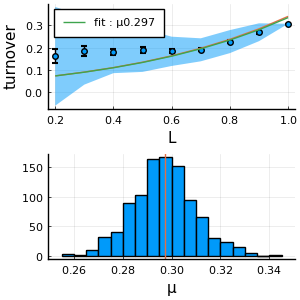

In [25]:
let d = 0.35
    t = estranged_turnover .|> mes2theory_estranged
    global b, Nthresh, mu
    function model(Ls, p)
        local mu = p[1]
        (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
        map( Ls ) do L
            min(1., W_estranged(d; b=b, μ=mu*L, T=log(Nthresh)/(b-d)))
        end
    end
    fit = curve_fit(model, Ls, mean.(t), [0.5])
    mu_fit = fit.param[1]

    p1 = scatter(Ls, mean.(t), ribbon=std.(t), yerror = std.(t)./sqrt.(length.(t)), lab="", xlab=:L, ylab=:turnover, legend=:bottomright)
    plot!(Ls, model(Ls, [mu]), lab="" )
    plot!(Ls, model(Ls, fit.param), lab="fit : μ$(round(mu_fit,digits=3))" )

    tvecs = [ rand.(t) for _=1:1000 ]
    fits = map( tp-> curve_fit(model, Ls, tp, [0.5]), tvecs)
    mu_fits = getindex.(getfield.(fits, :param),1)
    p2 = histogram(mu_fits, xlab="μ", lab="")
    vline!([mu_fit], lab="")

    println("μ : ", mu)
    println("mean fit : ", mu_fit)
    println("averaged fits : ", mean(mu_fits), " ± ", 1.96*std(mu_fits)/sqrt(length(mu_fits)))
    plot(p1, p2, layout=(2,1), size=(300,300), legend=:topleft)
end

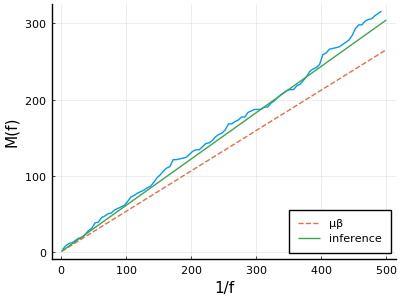

In [26]:
d_solve, mu_solve = 0.35, 0.3
res = 1/500

M(TumorGrowth.mutation_freqs(tumor).frequency, res = res, legend=:bottomright, lab="", size=(400,300))
plot!(1:1/res, x-> mu/(1-d/b)*x, lab="μβ", style=:dash)
plot!(1:1/res, x -> mu_solve/(1-d_solve/b)*x, lab="inference")

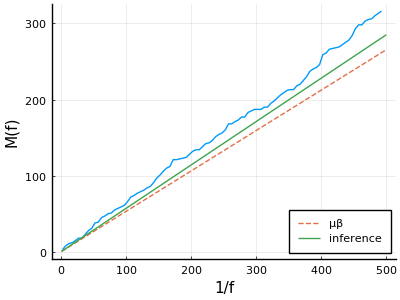

In [17]:
d_solve, mu_solve = 0.46, 0.19
res = 1/500

M(TumorGrowth.mutation_freqs(tumor).frequency, res = res, legend=:bottomright, lab="", size=(400,300))
plot!(1:1/res, x-> mu/(1-d/b)*x, lab="μβ", style=:dash)
plot!(1:1/res, x -> mu_solve/(1-d_solve/b)*x, lab="inference")

In [12]:
using TumorGrowth: multi_region_sequencing, haplotypes, data_import
import TumorGrowth
include(projectdir*"/simulated_tumors/path_format.jl")

In [13]:
tumorinfo = dir_info(projectdir*"/simulated_tumors/2d/bulk")
first(filter(row -> row.N==40000, tumorinfo), 6)

,N,b,d,μ,ρ,dim,id,path
,Int64,Float64,Float64,Float64,Float64,Int64,Int64,String
1,40000,1.0,0.4,0.2,Inf,2,8830,C:/Users/Arman Angaji/OneDrive - Universität zu Köln/Dokumente/Uni-Köln/Masterarbeit/Workspace/Julia_Master/MasterProject_Julia/simulated_tumors/2d/bulk\\tumor_N40000_b1.0_d0.4_μ0.2_ρInf_2d_id8830.csv


## Single cells

In [28]:
dfits = Float64[]
mufits = Float64[]

d, mu = 0.4, 0.2
let paths = filter(row -> row.d == d && row.μ == mu, tumorinfo).path
    prog = Progress(length(paths))
    for path in paths
        parameters = read_params(path)
        b, mu = parameters.b, parameters.μ
        Nthresh = 500
        
        tumor = data_import(path)
        htypes = unique(tumor.mutations)
        freqs = TumorGrowth.mutation_freqs(tumor) |> seq -> Dict(seq.mutation .=> seq.frequency)

        orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/Nthresh, htypes) ) )
        estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/Nthresh for m in muts), htypes) )
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |>
                df -> sum(df.isorphaned)/sum(df.isgreen) #|> mes2theory_orphaned

        d_solve = min(1., 2*log(Nthresh)*W_l)*b
        
        # get mu
        
        Ls = 0.1:0.1:1.
        reps = 10
        estranged_tumors = map( Ls ) do L
            [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
        end

        estranged_turnover = map(estranged_tumors) do set
                filter!(!isnan, map(set) do tumor
                    res = estranged_treeless(tumor)
                    sum(res.isestranged)/sum(res.isgreen)
                    end ) #|> mes2theory_estranged
            end
        
        function model(Ls, p)
            local mu = p[1]
            (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
            map( Ls ) do L
                min(1., W_estranged(d_solve; b=b, μ=mu*L, T=log(Nthresh)/(b-d_solve)))
            end
        end
        
        fit = curve_fit(model, Ls, mean.(estranged_turnover), [0.5])
        mu_fit = fit.param[1]
        
        push!(dfits, d_solve)
        push!(mufits, mu_fit)
        
        next!(prog)        
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:04


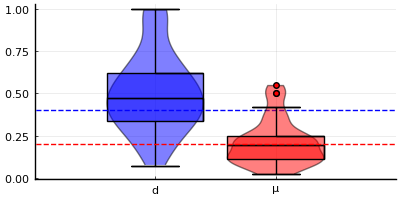

In [38]:
p = plot(legend=:none, size=(400,200), xlim=(0,3))
    
violin!([1], dfits, xticks=([1,2], [L"d", L"\mu"]), c = :blue, alpha=0.5)
boxplot!([1], dfits, fillalpha=0.5, c = :blue)
hline!([d], style=:dash, c = :blue)

violin!([2], mufits, c = :red, alpha=0.5)
boxplot!([2], mufits, fillalpha=0.5, c = :red)
hline!([mu], style=:dash, c = :red)

#### corrected

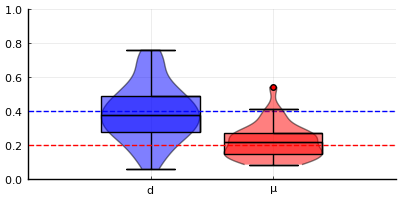

In [41]:
p = plot(legend=:none, size=(400,200), xlim=(0,3), ylim=(0,1))
    
violin!([1], dfits, xticks=([1,2], [L"d", L"\mu"]), c = :blue, alpha=0.5)
boxplot!([1], dfits, fillalpha=0.5, c = :blue)
hline!([d], style=:dash, c = :blue)

violin!([2], mufits, c = :red, alpha=0.5)
boxplot!([2], mufits, fillalpha=0.5, c = :red)
hline!([mu], style=:dash, c = :red)

### Simultaneous fit

In [46]:
dfits = Float64[]
mufits = Float64[]

d, mu = 0.4, 0.2
let paths = filter(row -> row.d == d && row.μ == mu, tumorinfo).path
    prog = Progress(length(paths))
    for path in paths
        parameters = read_params(path)
        b, mu = parameters.b, parameters.μ
        Nthresh = 500
        
        tumor = data_import(path)
        htypes = unique(tumor.mutations)
        freqs = TumorGrowth.mutation_freqs(tumor) |> seq -> Dict(seq.mutation .=> seq.frequency)

#         orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/Nthresh, htypes) ) )
        estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/Nthresh for m in muts), htypes) )
        
        Ls = 0.1:0.1:1.
        reps = 10
        estranged_tumors = map( Ls ) do L
            [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
        end

        estranged_turnover = map(estranged_tumors) do set
                filter!(!isnan, map(set) do tumor
                    res = estranged_treeless(tumor)
                    sum(res.isestranged)/sum(res.isgreen)
                    end ) |> mes2theory_estranged
            end
        
        function model(Ls, p)
            d, mu = p
            (d<0. || d>=1. || mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
            map( Ls ) do L
                min(1., W_estranged(d; b=b, μ=mu*L, T=log(Nthresh)/(b-d)))
            end
        end
        
        tvecs = [ rand.(estranged_turnover) for _=1:100 ]
        fits = map( tp-> curve_fit(model, Ls, tp, [0.5, 0.5]), tvecs)
        d_fits, mu_fits = getindex.(getfield.(fits, :param),1), getindex.(getfield.(fits, :param),2)
        d_err, mu_err = abs.(d_fits .- d), abs.(mu_fits .- mu)
        
        append!(dfits, d_fits)
        append!(mufits, mu_fits)

        next!(prog)        
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:10


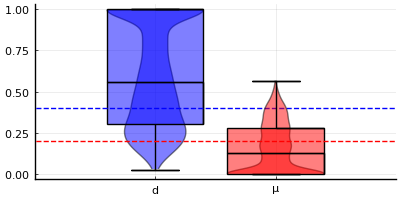

In [45]:
p = plot(legend=:none, size=(400,200), xlim=(0,3))
    
violin!([1], dfits, xticks=([1,2], [L"d", L"\mu"]), c = :blue, alpha=0.5)
boxplot!([1], dfits, fillalpha=0.5, c = :blue)
hline!([d], style=:dash, c = :blue)

violin!([2], mufits, c = :red, alpha=0.5)
boxplot!([2], mufits, fillalpha=0.5, c = :red)
hline!([mu], style=:dash, c = :red)

#### corrected

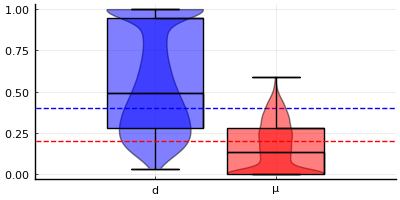

In [47]:
p = plot(legend=:none, size=(400,200), xlim=(0,3))
    
violin!([1], dfits, xticks=([1,2], [L"d", L"\mu"]), c = :blue, alpha=0.5)
boxplot!([1], dfits, fillalpha=0.5, c = :blue)
hline!([d], style=:dash, c = :blue)

violin!([2], mufits, c = :red, alpha=0.5)
boxplot!([2], mufits, fillalpha=0.5, c = :red)
hline!([mu], style=:dash, c = :red)

# Sampled tumors

## Results

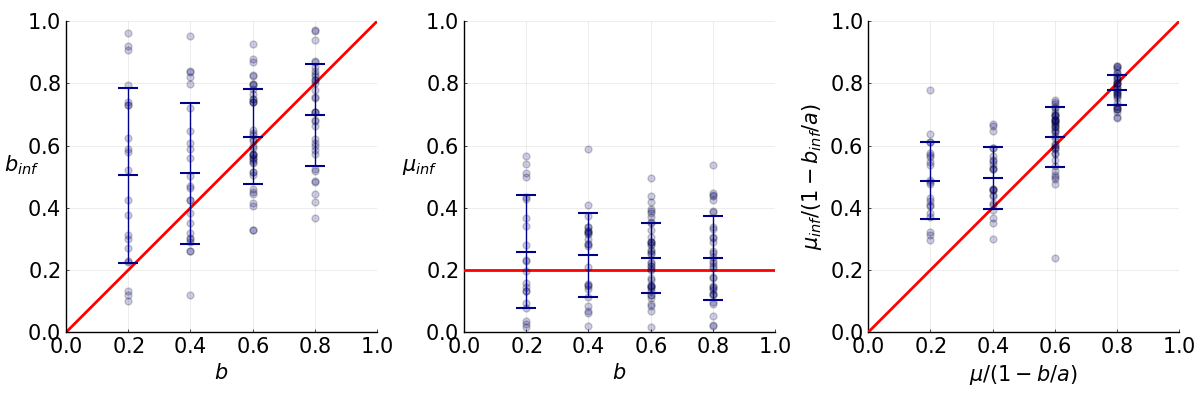

In [314]:
let mu = 0.2
    data = include("Turnover/turnover_data/inference_spatialdata_results.jl")[1]
    ds, dfits, mufits = data.ds, data.dfits, data.mufits
    bins = sort!(unique(ds))
    dfits_binned = [ [dfits[findall(isequal(mu), ds)]...] for mu in bins]
    mufits_binned = [ [mufits[findall(isequal(mu), ds)]...] for mu in bins]
    
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(1200,400),
             aspect_ratio=1, xaxis=(L"b", (0,1), 0.:0.2:1.), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15)

    plot!(p[1], 0:1,0:1, c=:red, lw=2.)
    scatter!(p[1], ds, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    scatter!(p[2], ds, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:1, 0:1, c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    scatter!(p[3], ds, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], bins, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
end

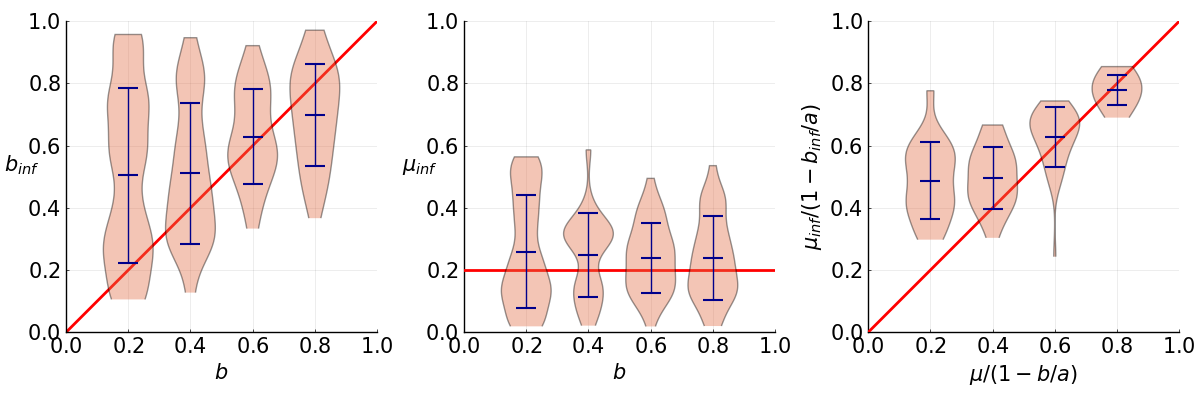

In [319]:
let mu = 0.2
    data = include("Turnover/turnover_data/inference_spatialdata_results.jl")[1]
    ds, dfits, mufits = data.ds, data.dfits, data.mufits
    bins = sort!(unique(ds))
    dfits_binned = [ [dfits[findall(isequal(mu), ds)]...] for mu in bins]
    mufits_binned = [ [mufits[findall(isequal(mu), ds)]...] for mu in bins]
    
    scalex = 5
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(1200,400),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    violin!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    violin!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    violin!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], bins*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
end

In [329]:
# savefig("Turnover/turnover_plots/inference/inference_spatial_N400_n270_thesis.pdf")

## Inference algorithms

In [36]:
# sa2sc_orphaned(tsa, p = [0.044, 0.631]) = @. (tsa-p[1])/p[2]
# sa2sc_estranged(tsa, p = [0.167, 0.742]) = @. (tsa-p[1])/p[2]

sa2sc_estranged (generic function with 2 methods)

In [18]:
ds = Float64[]
dfits = Float64[]
mufits = Float64[]

Nthresh_orph = 400
Nthresh_estr = 400
res = 1/400

let mu = 0.2
    paths = filter(row -> row.N == 10000 && row.μ == 0.2 && row.d in 0.2:0.2:0.8, tumorinfo).path
    prog = Progress(length(paths))
    for path in paths
        parameters = read_params(path)
        b, d = parameters.b, parameters.d
        
        tumor = data_import(path)
#         TumorGrowth.reduced_μ!(tumor, 0.5)
        freqs = TumorGrowth.mutation_freqs(tumor) |> seq -> Dict(seq.mutation .=> seq.frequency)
        
        samples, sampletumor = TumorGrowth.multi_region_sequencing(tumor; n=270, cells_per_sample = 20)
        htypes = map(eachrow(sampletumor)) do row
            filter(m-> freqs[m] > res, row.mutations[row.frequencies .>= 1/5])
        end |> unique
        
#         htypes = filter.(m-> freqs[m] > res, sample(tumor.mutations, 285, replace=false))
        
        orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/Nthresh_orph, htypes) ) )
        estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/Nthresh_estr for m in muts), htypes) )
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |>
                df -> sum(df.isorphaned)/sum(df.isgreen) #|> mes2theory_orphaned

        d_solve = min(1., 2*log(Nthresh_orph)*W_l)*b
        (isone(d_solve) || iszero(d_solve) || isnan(d_solve)) && continue
        
        # get mu
        
        Ls = 0.2:0.1:1.
        reps = 10
        estranged_tumors = map( Ls ) do L
            [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
        end

        estranged_turnover = map(estranged_tumors) do set
                filter!(!isnan, map(set) do tumor
                    res = estranged_treeless(tumor)
                    sum(res.isestranged)/sum(res.isgreen)
                    end ) #|> mes2theory_estranged
            end
        
        Ls, estranged_turnover = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])
        
        function model(Ls, p)
            local mu = p[1]
            (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
            map( Ls ) do L
                min(1., W_estranged(d_solve; b=b, μ=mu*L, T=log(Nthresh_estr)/(b-d_solve)))
            end
        end
        
        fit = curve_fit(model, Ls, mean.(estranged_turnover), [(1-d_solve)/2])
        mu_fit = fit.param[1]
        mu_fit == (1-d_solve)/2 && continue
        
        push!(ds, d)
        push!(dfits, d_solve)
        push!(mufits, mu_fit)
        
        next!(prog)
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:09:26


In [18]:
dataset = include("turnover_data/inference_spatialdata_results.jl")[1]
ds, dfits, mufits = dataset.ds, dataset.dfits, dataset.mufits;

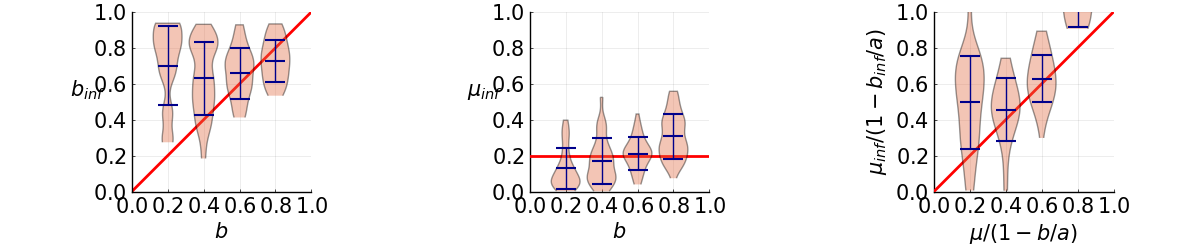

In [39]:
plot_series_violin(ds, dfits, mufits; mu=0.2, size=(800,300))

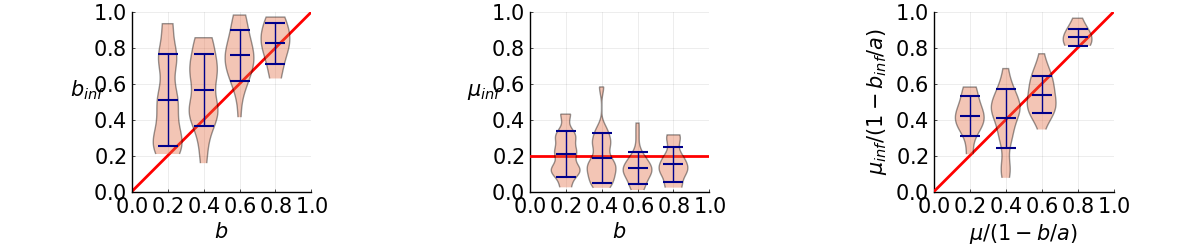

In [36]:
plot_series_violin(ds, dfits, mufits; mu=0.2, size=(800,300))

> single cell sampling, n 270, N 150, res 500

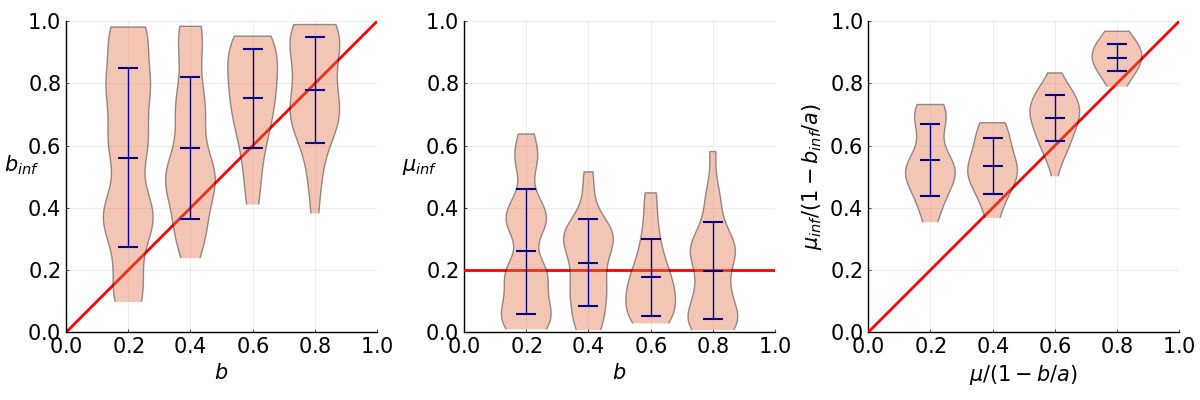

In [270]:
plot_series_violin(ds, dfits, mufits; mu=0.2, size=(800,300))

> 300, 200, 20, 1/3

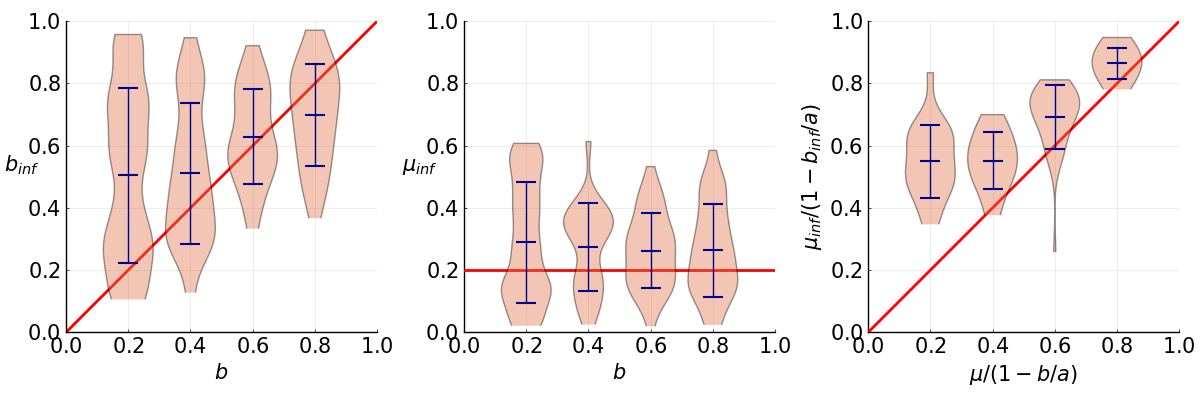

In [273]:
plot_series_violin(ds, dfits, mufits; mu=0.2, size=(800,300))

> 200, 200, 20, 1/3

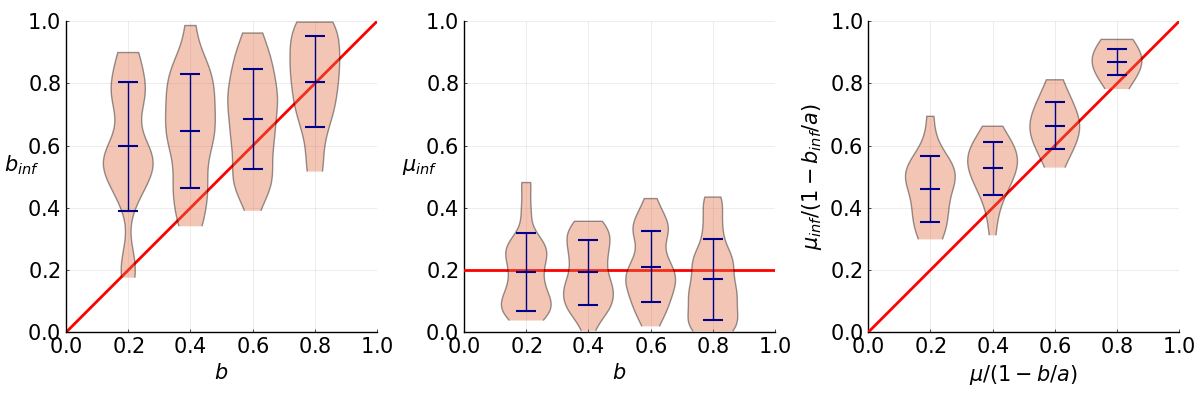

In [264]:
plot_series_violin(ds, dfits, mufits; mu=0.2, size=(800,300))

> 400, 270, 20, 1/3

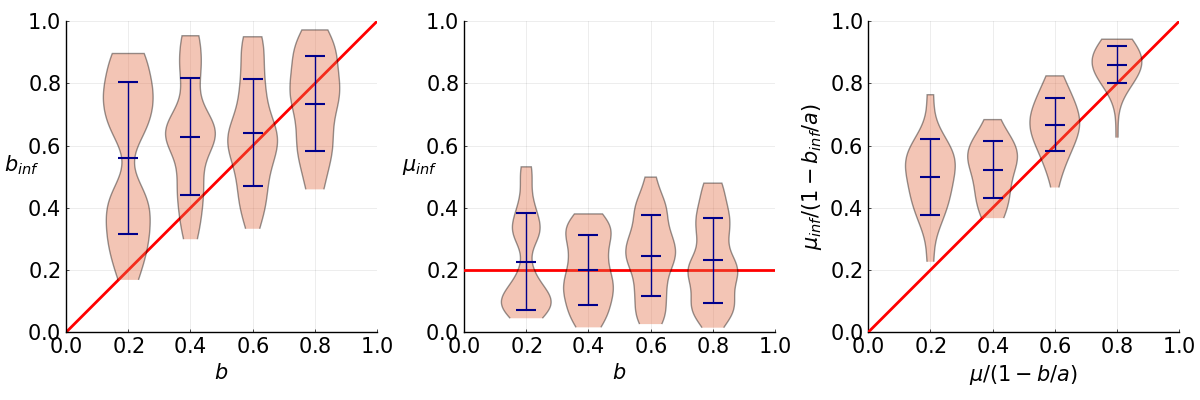

In [267]:
plot_series_violin(ds, dfits, mufits; mu=0.2, size=(800,300))

> 300, 270, 20, 1/3

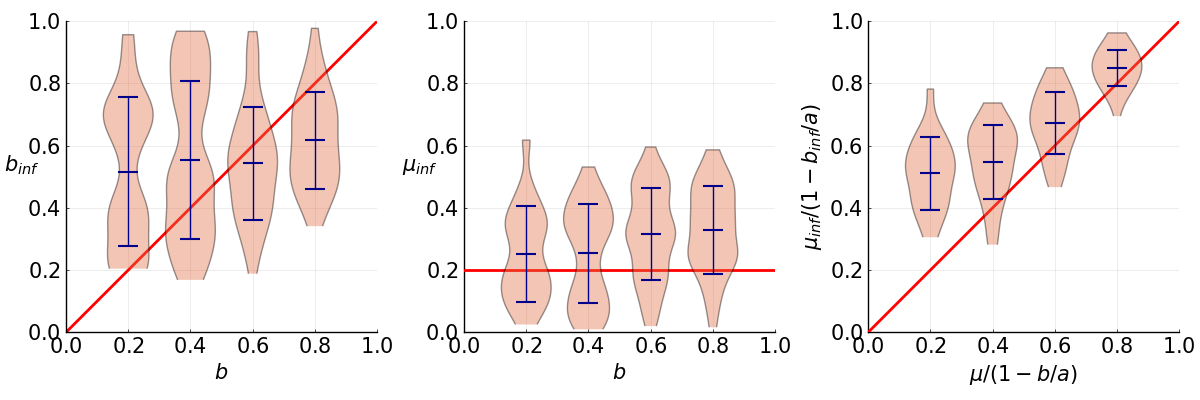

In [277]:
plot_series_violin(ds, dfits, mufits; mu=0.2, size=(800,300))

> 200, 270, 20, 1/3

In [23]:
# offspring_clade_fit, orphaned_clade_fit = [-17.652261535633116, 1.3496472290222599], [3.8407907093683753, 1.2014373638680613]
# offspring_clone_fit, estranged_clone_fit = [1.9828890232790028, 0.7950688448535779], [1.5051541766093208, 0.8536705669019635]

# n 285, Nthresh_orph 400, Nthresh_estr 400, res 1/10000, 1/3

# offspring_clade_fit, orphaned_clade_fit = [-3.1393344953000137, 0.3694065504550832], [0.28213233319606085, 0.9337963349045757]
# offspring_clone_fit, estranged_clone_fit = [2.0460394588109088, 0.27062540749285335], [1.742873794475777, 0.3815998563513362]

# n 30, Nthresh_orph 200, Nthresh_estr 50, res 1/200, 1/3

# offspring_clade_fit, orphaned_clade_fit = [-12.265472456868345, 2.0721200281841874], [13.515351430887435, 1.95984197842931]
# offspring_clone_fit, estranged_clone_fit = [18.939600447524324, 2.521358909445503], [7.17261825141223, 3.306604792822085]

# n 285, Nthresh_orph 285, Nthresh_estr 50, res 1/285, 1/3, sangerlike-freqs (samplenumbers)

# offspring_clade_fit, orphaned_clade_fit = [6.477418192491858, 1.140429004503049], [0.016633669706656435, 0.9771120277921564]
# offspring_clone_fit, estranged_clone_fit = [0.7841582064297806, 1.0084602368866327], [0.10214122375441756, 0.9079758852470377]

# n 285, Nthresh_orph 285, Nthresh_estr 50, res 1/285, 1/3, mutnumb 35

offspring_clade_fit, orphaned_clade_fit, offspring_clone_fit, estranged_clone_fit = [0,1],[0,1],[0,1],[0,1]

function correct_orph(df_orph, p = [offspring_clade_fit, orphaned_clade_fit])
    max(0, sum(df_orph.isorphaned)- p[2][1]) / p[2][2] / max(0, sum(df_orph.isgreen) - p[1][1]) * p[1][2]
end
function correct_estr(df_estr, p = [offspring_clone_fit, estranged_clone_fit])
    max(0, sum(df_estr.isestranged)- p[2][1]) / p[2][2] / max(0, sum(df_estr.isgreen) - p[1][1]) * p[1][2]
end

correct_estr (generic function with 2 methods)

In [5]:
ds = Float64[]
dfits = Float64[]
mufits = Float64[]

n_samples = 285
samplecutoff = 1/3
res = 1/600
Nthresh_orph = 500
Nthresh_estr = 80
# mutnumb = 35

let
    data = filter(row -> row.N == 10000 && row.μ == 0.2 && row.d in 0.:0.2:0.8, tumorinfo)
    prog = Progress(nrow(data))
    for row in eachrow(data)

        tumor, b, d = row.tumor, row.b, row.d
        
        freqs = TumorGrowth.mutation_freqs(tumor) |> seq -> Dict(seq.mutation .=> seq.frequency)

#         subsampled_muts = unique(vcat(tumor.mutations...)) |> all_m -> sample(all_m, min(length(all_m),mutnumb), replace=false)
#         filter!.(in(subsampled_muts), tumor.mutations)
        
        samples, sampletumor = TumorGrowth.multi_region_sequencing(tumor; n=n_samples, cells_per_sample = 0)
        
#         freqs = TumorGrowth.mutation_freqs(sampletumor) |> seq -> Dict(seq.mutation .=> seq.frequency)
        
        htypes = map(eachrow(sampletumor)) do row
            row.mutations[row.frequencies .>= samplecutoff]
        end |> unique
#         htypes = unique(tumor.mutations)
        
#         htypes = sample(tumor.mutations, 285, replace=false)
        
        orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/Nthresh_orph, htypes) ) )
        estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/Nthresh_estr for m in muts), htypes) )
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> correct_orph

        d_solve = min(1., 2*log(Nthresh_orph)*W_l)*b
        (isone(d_solve) || iszero(d_solve) || isnan(d_solve)) && continue
        
        # get mu
        W_c = estranged_treeless(estranged_tumor) |> correct_estr

        try 
            mu_fit, n = bisection(mu -> min(1., W_estranged(d_solve; b=b, μ=mu, T=log(Nthresh_estr)/(b-d_solve)))- W_c, [0.01,0.99], 100)
            push!(ds, d)
            push!(dfits, d_solve)
            push!(mufits, mu_fit)
            next!(prog)
        catch e
        end
        sleep(0.1)
    end
end

LoadError: UndefVarError: data_import not defined

In [ ]:
plot_series(ds, dfits, mufits; mu, size=(800,300))

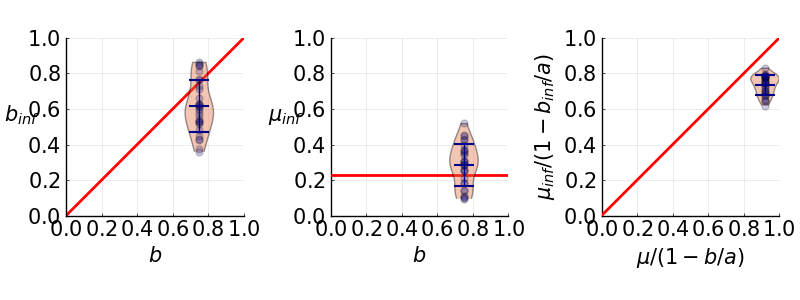

In [73]:
let mu = 0.23
    scalex = 5
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(800,300),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    violin!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    violin!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    violin!(p[3], mu./(1 .-ds)*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], mu./(1 .-ds)*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], mu./(1 .-bins)*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

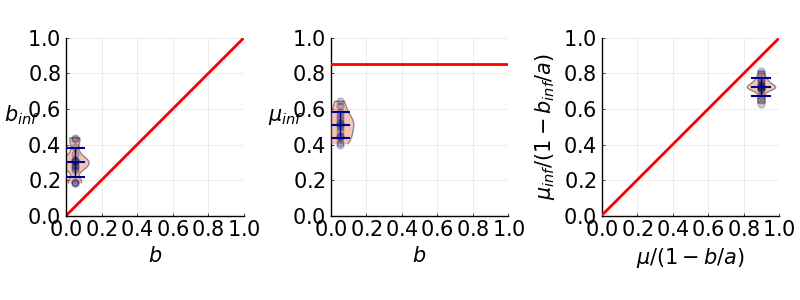

In [76]:
let mu = 0.855
    scalex = 5
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(800,300),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    violin!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    violin!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    violin!(p[3], mu./(1 .-ds)*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], mu./(1 .-ds)*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], mu./(1 .-bins)*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

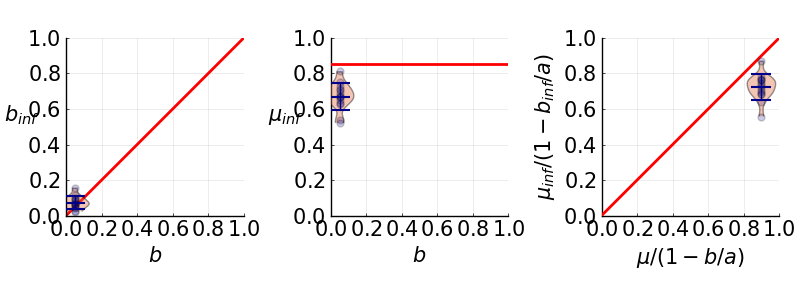

In [79]:
let mu = 0.855
    scalex = 5
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(800,300),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    violin!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    violin!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    violin!(p[3], mu./(1 .-ds)*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], mu./(1 .-ds)*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], mu./(1 .-bins)*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

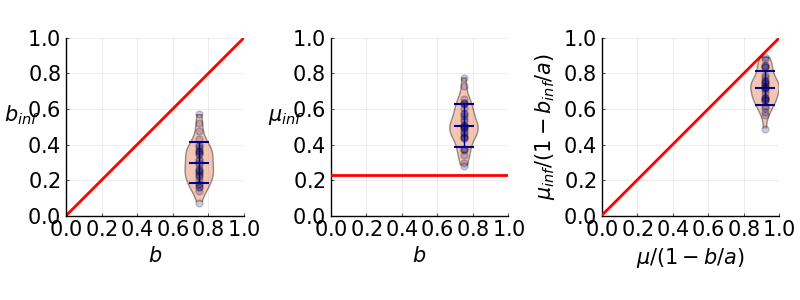

In [82]:
let mu = 0.23
    scalex = 5
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(800,300),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    violin!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    violin!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    violin!(p[3], mu./(1 .-ds)*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], mu./(1 .-ds)*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], mu./(1 .-bins)*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

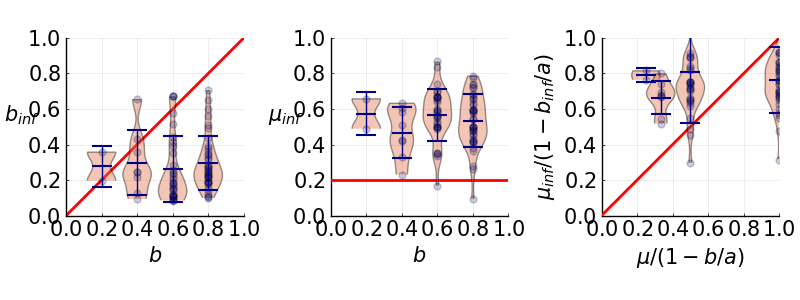

In [32]:
let mu = 0.2
    scalex = 5
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(800,300),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    violin!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    violin!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    violin!(p[3], mu./(1 .-ds)*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], mu./(1 .-ds)*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], mu./(1 .-bins)*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

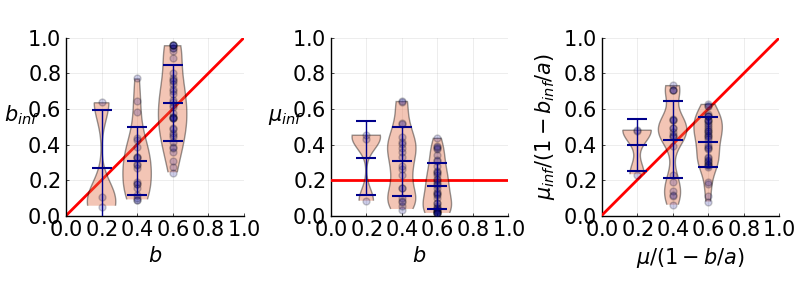

In [34]:
let mu = 0.2
    scalex = 5
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(800,300),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    violin!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    violin!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    violin!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], bins*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

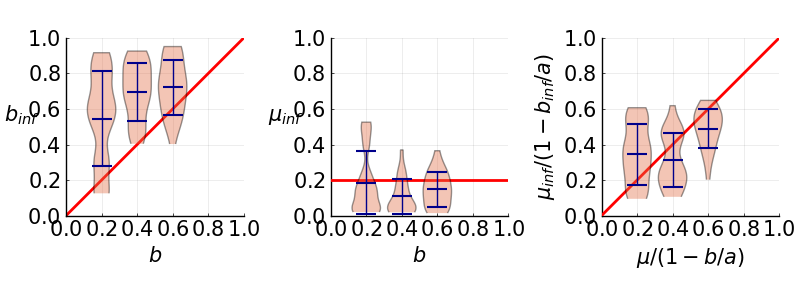

In [30]:
let mu = 0.2
    scalex = 5
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(800,300),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    violin!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    violin!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    violin!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], bins*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

> n 285, Nthresh_orph 285, Nthresh_estr 50, res 1/285, 1/3, sangerlike-freqs (samplenumbers)

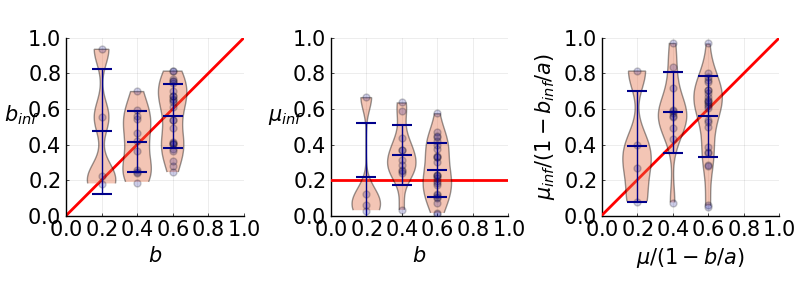

In [44]:
let mu = 0.2
    scalex = 5
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(800,300),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    violin!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    violin!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    violin!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], bins*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

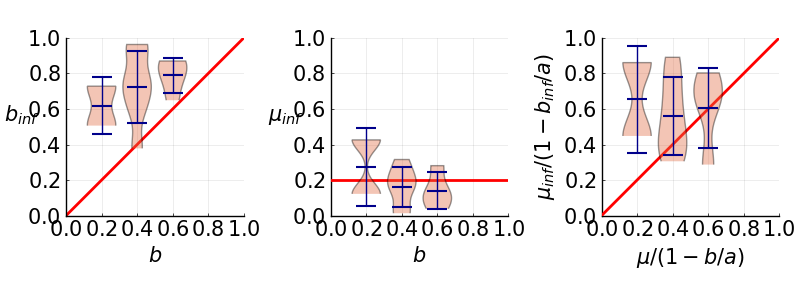

In [23]:
let mu = 0.2
    scalex = 5
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(800,300),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    violin!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    violin!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    violin!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], bins*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

> n 30, Nthresh_orph 200, Nthresh_estr 50, res 1/200, 1/3

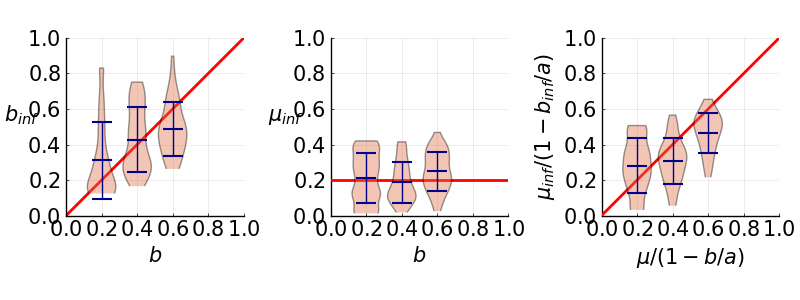

In [13]:
let mu = 0.2
    scalex = 5
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(800,300),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    violin!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    violin!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    violin!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], bins*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

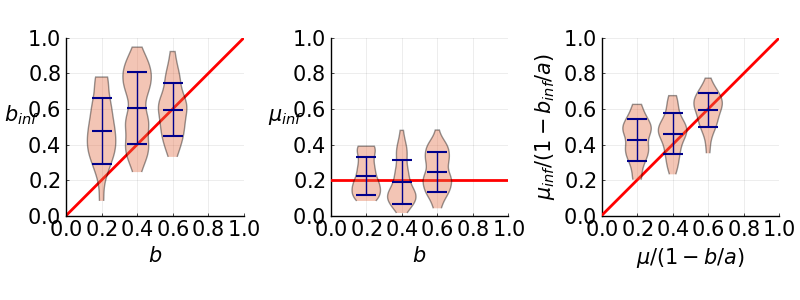

In [10]:
let mu = 0.2
    scalex = 5
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(800,300),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    violin!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    violin!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    violin!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], bins*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

> n 285, Nthresh_orph 400, Nthresh_estr 400, res 1/10000, 1/3

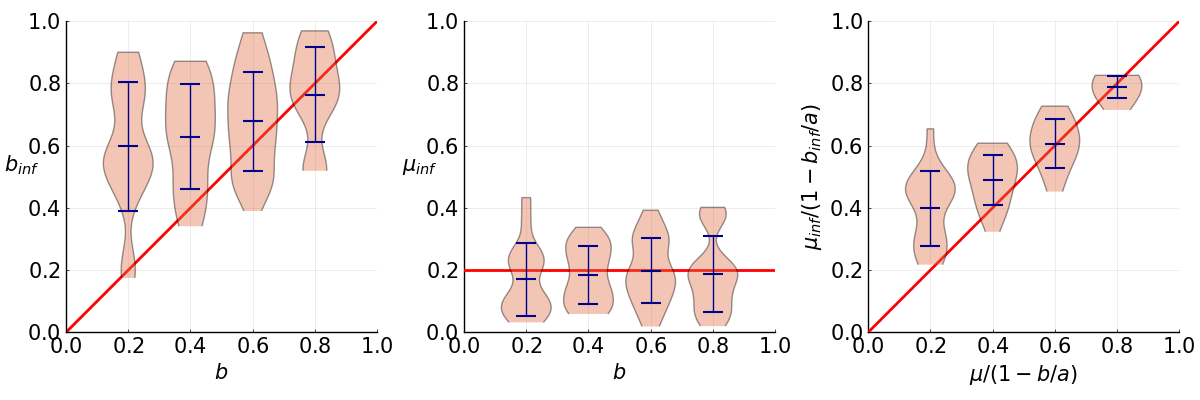

In [169]:
let mu = 0.2
    scalex = 5
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(1200,400),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    violin!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    violin!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    violin!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], bins*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

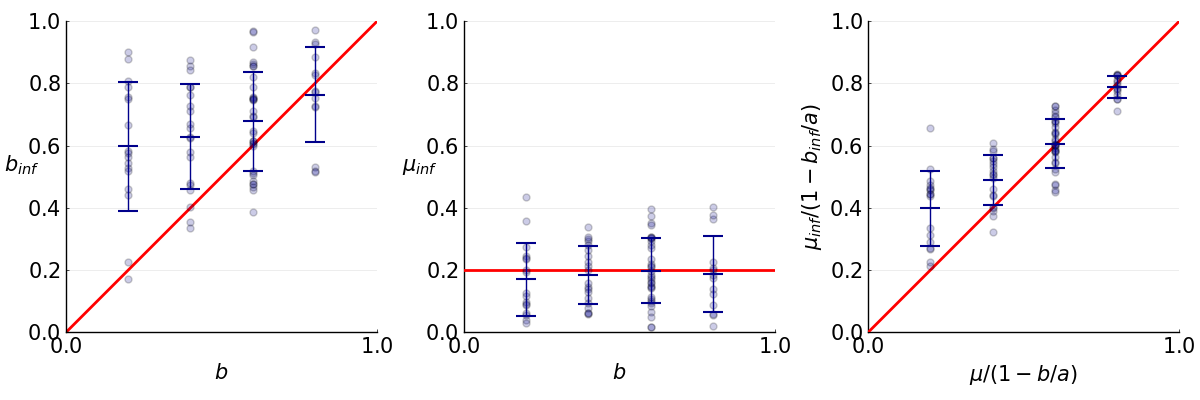

In [159]:
let mu = 0.2
    scalex = 1
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(1200,400),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    scatter!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    scatter!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    scatter!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], bins*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

> 400, 270, 20, 1/3

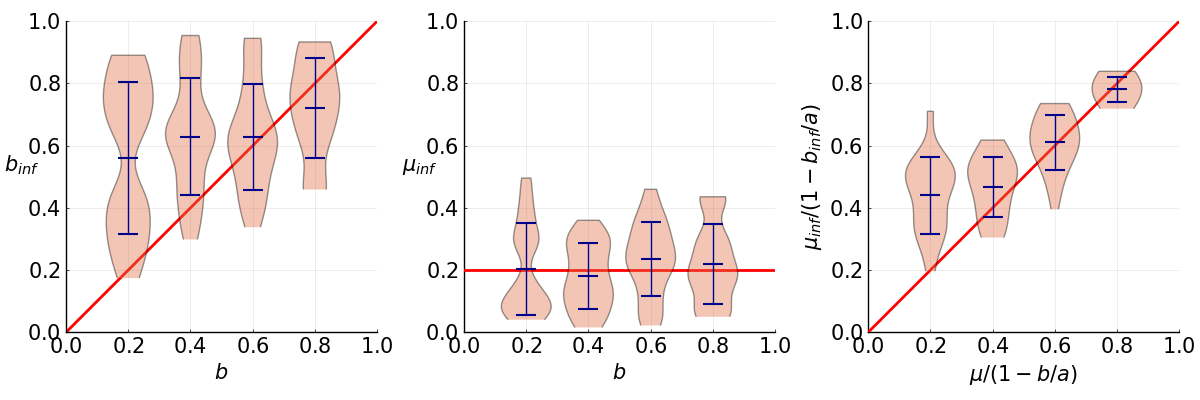

In [149]:
let mu = 0.2
    scalex = 5
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(1200,400),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    violin!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    violin!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    violin!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], bins*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

> 300, 270, 20, 1/3

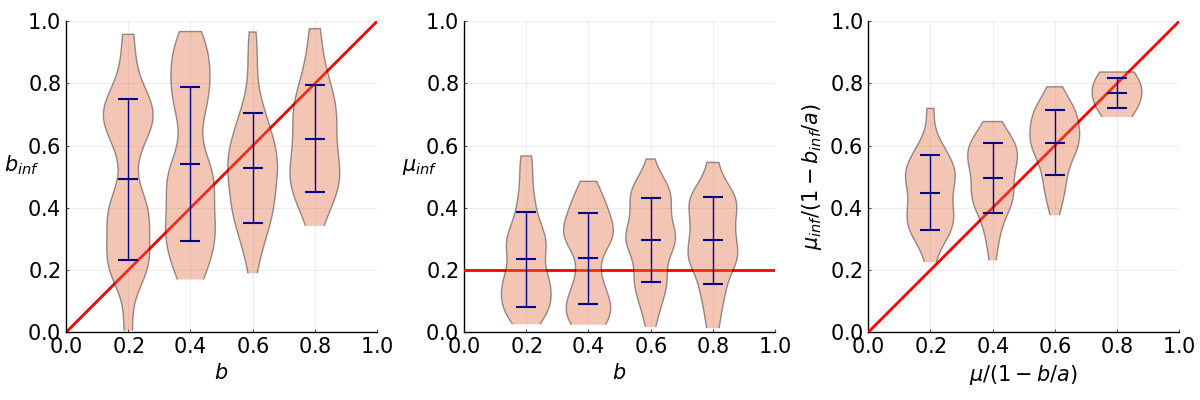

In [162]:
let mu = 0.2
    scalex = 5
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(1200,400),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    violin!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    violin!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    violin!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], bins*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

> 200, 270, 20, 1/3

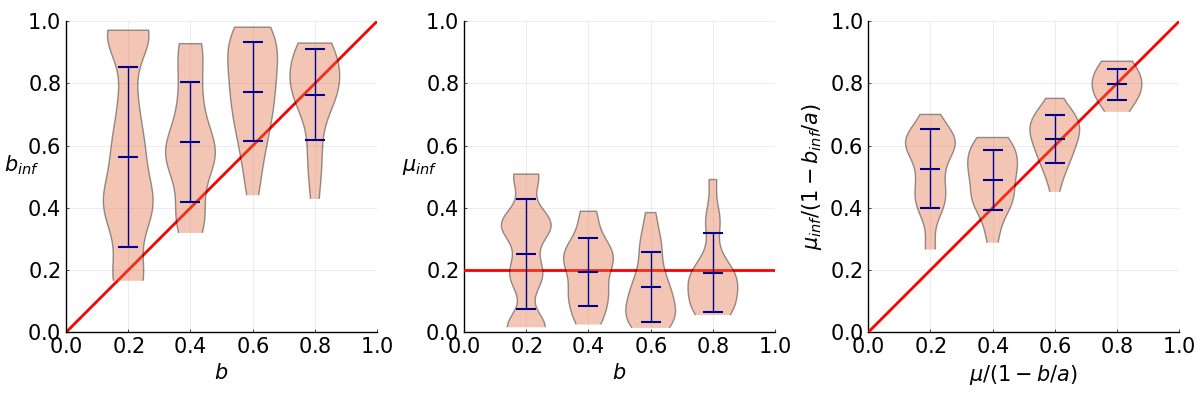

In [37]:
let mu = 0.2
    scalex = 5
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(1200,400),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    violin!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    violin!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    violin!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], bins*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

> 400, 200, 20, 1/3

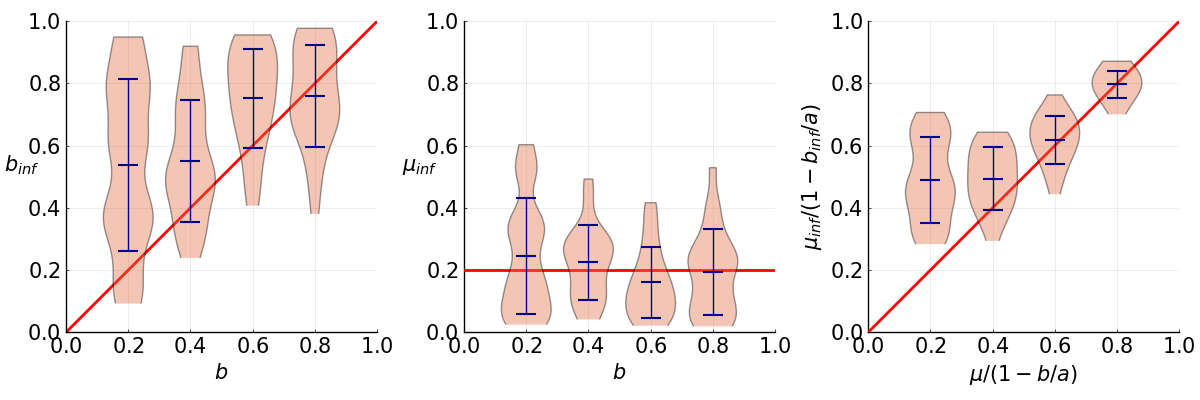

In [31]:
let mu = 0.2
    scalex = 5
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(1200,400),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    violin!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    violin!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    violin!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], bins*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

> 300, 200, 20, 1/3

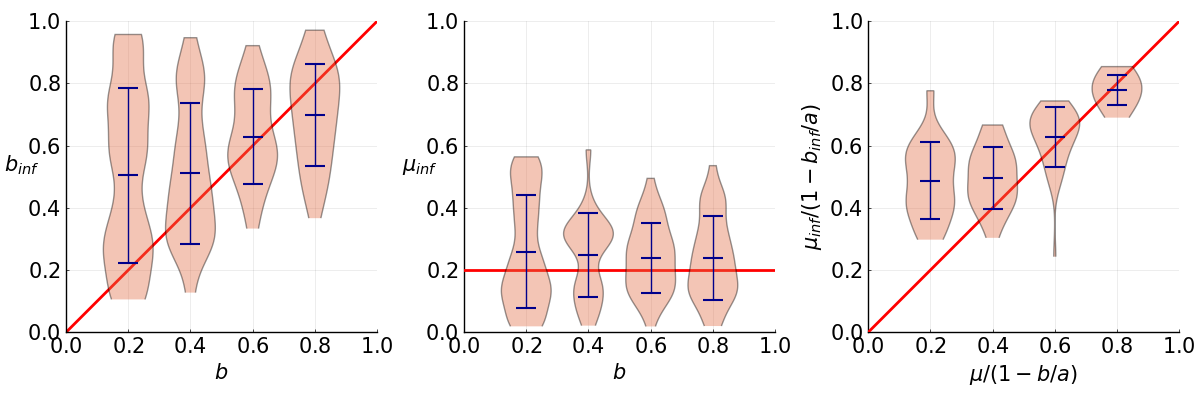

In [40]:
let mu = 0.2
    scalex = 5
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(1200,400),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    violin!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    violin!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    violin!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], bins*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

> 200, 200, 20, 1/3

In [22]:
path = filter(row -> row.N==10000 && row.d == 0.4, tumorinfo).path |> rand
tumor = data_import(path);

┌ Warning: This method assumes mutations to be ordered by occurence!
└ @ TumorGrowth C:\Users\Arman Angaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\TumorGrowth\src\analysis.jl:104


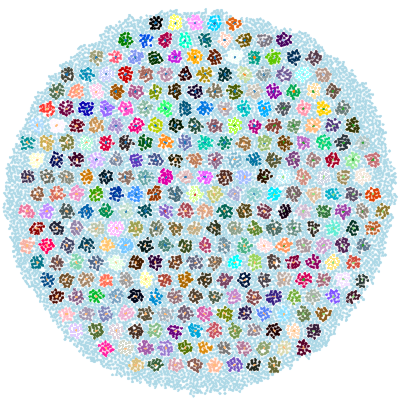

In [42]:
samples, sampletumor = TumorGrowth.multi_region_sequencing(tumor; n=300, cells_per_sample=15)
scene = TumorGrowth.plotting(tumor, color=:lightblue, size=(400,400))
cs = distinguishable_colors(length(samples))
for (i,sample) in enumerate(samples)
    TumorGrowth.plotting!(scene , sample, color=cs[i])
end
TumorGrowth.plotting_colored_mutations!(scene, sampletumor)